# Comparison of SBP-SAT and SPECFEM2D in a two-layers medium

### with grid coarsening x 3

In [1]:
import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

Create directories to store data and figures

In [2]:
!mkdir -p ../dat ../fig

### Generate source wavelet (Ricker)

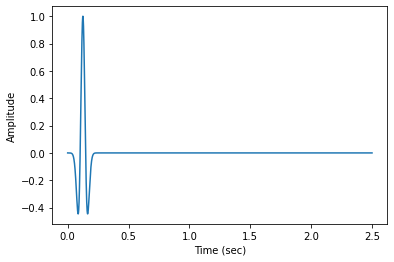

In [3]:
nt=5001
dt=0.0005
ot=0
wc=0.01
sigma=math.sqrt(2)/(math.pi*wc)
src1 = signal.ricker(2*nt-1, sigma)
src1=src1[4750:4750+nt]
src1=src1*1.0/np.max(src1)

plt.plot(np.linspace(ot,(nt-1)*dt,nt),src1)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.show()

In [4]:
# save to text file for SPECFEM2D
file = open('../dat/src1.txt', 'w')
for i in range(nt):
    print("%.6f %.6f" %(i*dt+ot,src1[i]), file=file)
file.close()

# save to numpy
np.save('../dat/src1',src1)

# convert to SEPlib for SBP-SAT
!sep2numpy.py --input ../dat/src1.npy --mode 1 --datapath ${PWD}/../dat/ --output ../dat/src1.H

# set the sampling (in sec) in the description file
!echo d1=0.0005 >> ../dat/src1.H

### Generate a homogeneous isotropic elastic model

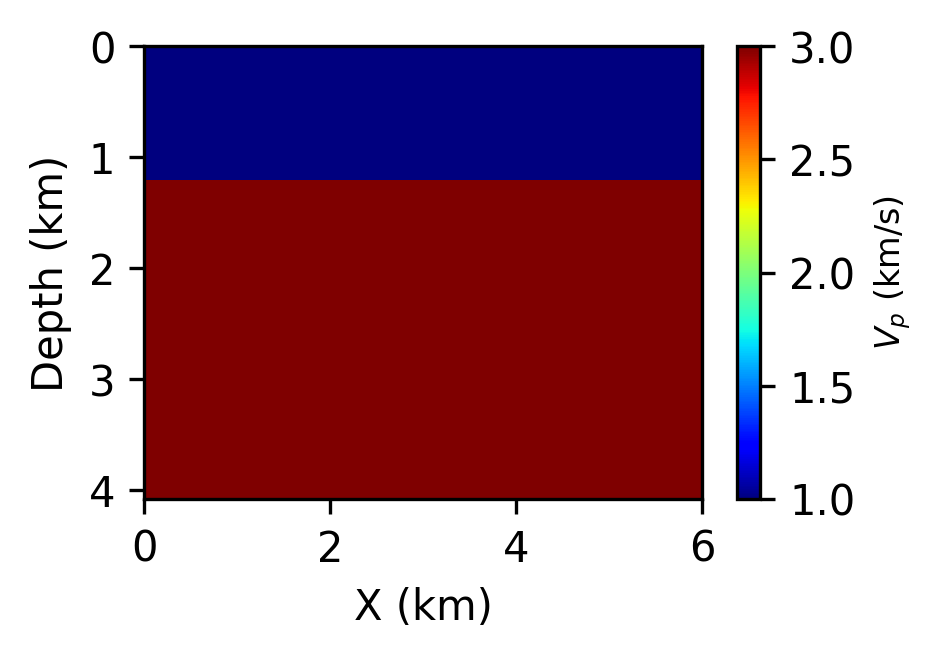

In [10]:
# elastic model
emodel=np.zeros((3,401,193))
emodel[0,:,:]=3 # Vp in km/s
emodel[1,:,:]=1 # Vs in km/s
emodel[2,:,:]=2.5 # Density in g/cc

# full Vp model for plotting (acoustic on top then elastic)
aemodel=np.full((401,273),3)
aemodel[:,:81]=1.5

fig, ax = plt.subplots(1,1,figsize=(3, 2),dpi=300)
im=ax.imshow(np.transpose(aemodel),interpolation='none',aspect="auto",extent=[0,6.,4.08,0],cmap='jet')
ax.set(xlabel='X (km)')
ax.set(ylabel='Depth (km)')
cbar=fig.colorbar(im, ax=ax,format='%.'+str(1)+'f',aspect=20)
cbar.set_label(label=r'$V_p$ (km/s)',size=8)

In [11]:
# save to numpy
np.save('../dat/emodel1',emodel)

# convert to SEPlib for SBP-SAT
!sep2numpy.py --input ../dat/emodel1.npy --output ../dat/emodel1.H --mode 1 --datapath ${PWD}/../dat/
!echo o1=1.2 d1=0.015 d2=0.015 >> ../dat/emodel1.H

### Run modeling using SPECFEM2D

In [7]:
# generate particle velocity recordings
!bash ../specfem2d/run3_v.sh

running SPECFEM2D to model particle velocity with provided source time function in txt file: Fri Jul 15 19:01:43 UTC 2022
/home/sbp_sat_geophysics_2022/notebooks


(will take about 5 minutes)


   setting up the test


  running mesher...


 **********************************************
 *** Specfem 2-D Mesher - serial version    ***
 **********************************************

 Running Git version of the code corresponding to commit 7e019b622587b3abce752c6ebb0ec1033de8d848
 dating From Date:   Tue Jul 12 11:29:06 2022 +0300

 Reading the parameter file...

 Title of the simulation: Flat fluid/solid interface


 Receiver lines:
   Nb of line sets =            1

 Materials:
   Nb of solid, fluid or porous materials =            2

 --------
 Material #           1  isotropic
 rho,cp,cs   =    2500.0000000000000        3000.0000000000000        1000.0000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is solid
 --------
 Material #       

 Mesh numbering:
   Total number of elements:         6800

   Total number of acoustic elements           =         2000
   Total number of elastic/visco/poro elements =         4800

 Exact total number of grid points in the mesh:       109473

 Approximate number of acoustic degrees of freedom in the mesh:        32198
 Approximate number of elastic degrees of freedom in the mesh:       154550
   (there are 2 degrees of freedom per point for elastic elements)

 Approximate total number of degrees of freedom in the mesh
 (sum of the two values above):       186748

  (for simplicity viscoelastic or poroelastic elements, if any,
   are counted as elastic in the above three estimates;
   in reality they have more degrees of freedom)

 Mesh dimensions:
   Xmin,Xmax of the whole mesh =    0.0000000000000000        6000.0000000000000     
   Zmin,Zmax of the whole mesh =    0.0000000000000000        4080.0000000000005     

 Material properties:
   MODEL                 : default
   nspec


 ******************************************************************
Time step number       5   t =    0.0020 s out of    5001
 ******************************************************************
 We have done    7.99999982E-02 % of the total
 Max norm of vector field in solid (elastic) =    0.00000000    
 Max absolute value of scalar field in fluid (acoustic) =    5.96449837E-14
 Elapsed time in seconds =    8.8000059127807617E-002
 Elapsed time in hh:mm:ss =      0 h 00 m 00 s
 Mean elapsed time per time step in seconds =    1.7600011825561524E-002
 Time steps remaining =         4996
 Estimated remaining time in seconds =    87.929659080505374     
 Estimated remaining time in hh:mm:ss =      0 h 01 m 27 s
 Estimated total run time in seconds =    88.017659139633182     
 Estimated total run time in hh:mm:ss =      0 h 01 m 28 s
 The run will finish approximately on: Fri Jul 15, 2022 19:03

 Creating color image of size          800  x          575  for time step            5
 drawi

 Creating color image of size          800  x          575  for time step         3500
 drawing scalar image of the forward wavefield displacement...
 Color image maximum amplitude =    5.5276909351892334E-013
 Color image created


 ******************************************************************
Time step number    4000   t =    1.9995 s out of    5001
 ******************************************************************
 We have done    79.9800034     % of the total
 Max norm of vector field in solid (elastic) =    4.11054735E-13
 Max absolute value of scalar field in fluid (acoustic) =    1.41312437E-08
 Elapsed time in seconds =    76.714999914169312     
 Elapsed time in hh:mm:ss =      0 h 01 m 16 s
 Mean elapsed time per time step in seconds =    1.9178749978542329E-002
 Time steps remaining =         1001
 Estimated remaining time in seconds =    19.197928728520871     
 Estimated remaining time in hh:mm:ss =      0 h 00 m 19 s
 Estimated total run time in seconds =    95.9129

In [8]:
# copy the output
!cp ../dat/OUTPUT_FILES/AA.S0001.BXX.semd ../dat/specfem2d_data3_vx.txt
!cp ../dat/OUTPUT_FILES/AA.S0001.BXZ.semd ../dat/specfem2d_data3_vz.txt

In [9]:
# generate pressure recording
!bash ../specfem2d/run3_p.sh

running SPECFEM2D to model particle velocity with provided source time function in txt file: Fri Jul 15 19:03:23 UTC 2022
/home/sbp_sat_geophysics_2022/notebooks


(will take about 5 minutes)


   setting up the test


  running mesher...


 **********************************************
 *** Specfem 2-D Mesher - serial version    ***
 **********************************************

 Running Git version of the code corresponding to commit 7e019b622587b3abce752c6ebb0ec1033de8d848
 dating From Date:   Tue Jul 12 11:29:06 2022 +0300

 Reading the parameter file...

 Title of the simulation: Flat fluid/solid interface


 Receiver lines:
   Nb of line sets =            1

 Materials:
   Nb of solid, fluid or porous materials =            2

 --------
 Material #           1  isotropic
 rho,cp,cs   =    2500.0000000000000        3000.0000000000000        1000.0000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is solid
 --------
 Material #       

 Mesh numbering:
   Total number of elements:         6800

   Total number of acoustic elements           =         2000
   Total number of elastic/visco/poro elements =         4800

 Exact total number of grid points in the mesh:       109473

 Approximate number of acoustic degrees of freedom in the mesh:        32198
 Approximate number of elastic degrees of freedom in the mesh:       154550
   (there are 2 degrees of freedom per point for elastic elements)

 Approximate total number of degrees of freedom in the mesh
 (sum of the two values above):       186748

  (for simplicity viscoelastic or poroelastic elements, if any,
   are counted as elastic in the above three estimates;
   in reality they have more degrees of freedom)

 Mesh dimensions:
   Xmin,Xmax of the whole mesh =    0.0000000000000000        6000.0000000000000     
   Zmin,Zmax of the whole mesh =    0.0000000000000000        4080.0000000000005     

 Material properties:
   MODEL                 : default
   nspec


 ******************************************************************
Time step number       5   t =    0.0020 s out of    5001
 ******************************************************************
 We have done    7.99999982E-02 % of the total
 Max norm of vector field in solid (elastic) =    0.00000000    
 Max absolute value of scalar field in fluid (acoustic) =    5.96449837E-14
 Elapsed time in seconds =    9.8000049591064453E-002
 Elapsed time in hh:mm:ss =      0 h 00 m 00 s
 Mean elapsed time per time step in seconds =    1.9600009918212889E-002
 Time steps remaining =         4996
 Estimated remaining time in seconds =    97.921649551391596     
 Estimated remaining time in hh:mm:ss =      0 h 01 m 37 s
 Estimated total run time in seconds =    98.019649600982660     
 Estimated total run time in hh:mm:ss =      0 h 01 m 38 s
 The run will finish approximately on: Fri Jul 15, 2022 19:05

 Creating color image of size          800  x          575  for time step            5
 drawi

 Creating color image of size          800  x          575  for time step         3500
 drawing scalar image of the forward wavefield displacement...
 Color image maximum amplitude =    5.5276909351892334E-013
 Color image created


 ******************************************************************
Time step number    4000   t =    1.9995 s out of    5001
 ******************************************************************
 We have done    79.9800034     % of the total
 Max norm of vector field in solid (elastic) =    4.11054735E-13
 Max absolute value of scalar field in fluid (acoustic) =    1.41312437E-08
 Elapsed time in seconds =    78.845000028610229     
 Elapsed time in hh:mm:ss =      0 h 01 m 18 s
 Mean elapsed time per time step in seconds =    1.9711250007152556E-002
 Time steps remaining =         1001
 Estimated remaining time in seconds =    19.730961257159709     
 Estimated remaining time in hh:mm:ss =      0 h 00 m 19 s
 Estimated total run time in seconds =    98.5759

In [10]:
# copy the output
!cp ../dat/OUTPUT_FILES/AA.S0001.POT.semx ../dat/specfem2d_data3_p.txt

### Run modeling using FWI2D

In [12]:
!WE_MODELING.x source=../dat/src1.H model=../dat/emodel1.H output=../dat/fd_data.H datapath=${PWD}/../dat/ acoustic_elastic=1 acoustic_source=1 acoustic_wavefield=1 water_velocity=1.5 water_density=1 \
dt=0.0005 resampling=linear sub=100 fmax=30 verbose=3 \
ns=1 sx0=2.4 sz0=1.12 nr=1 rx0=3.44 rz0=1.2 seismotype=1 \
bc_top=1 free_surface_stiffness=2.0 bc_bottom=2 bc_left=2 bc_right=2 taper_top=0 taper_bottom=35 taper_left=35 taper_right=35 taper_strength=0.1


 Subsurface model geometry
xmin=0.00000 km, xmax=6.00000 km, dx=0.01500 km, nx=401
zmin=1.20000 km, zmax=4.08000 km, dz=0.01500 km, nz=193
A fluid layer is implicitly added on top of the model, all the way up to z=0 km with nz=81 samples v=1.50 km/s and rho=1.00 g/cc

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 35	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 35	 taper type = cosine squared
Right boundary condition = locally absorbing	 taper size = 35	 taper type = cosine squared

 Sources' and receivers' geometry
Sources' and receivers' coordinates are read from parameters list
Receivers are dual point measurement of type hydraulic pressure and particle velocity
Number of sources = 1
All sources must fall within the fluid layer
Shot 0 located at x=2.40000 km, z=1.12000 km, has 1 receivers
Total number of 3-components receivers to be mo

In [13]:
# convert to numpy
!sep2numpy.py --input ../dat/fd_data.H --output ../dat/fd_data3 --mode 0